In [40]:
import numpy as np
import os
import random
from sys import platform as sys_pf

import matplotlib
if sys_pf == 'darwin':
	matplotlib.use("TkAgg")
    
from matplotlib import pyplot as plt

import keras
import tensorflow as tf

from keras.models import Sequential, Model
from keras.models import load_model

from keras.applications.vgg16 import VGG16

from keras.layers import Flatten
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input

from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from sklearn.utils import shuffle

import h5py

Some utility functions 

In [5]:
def load_img(fn):
	I = plt.imread(fn)
	I = np.array(I)
	return I
# convert to str and add leading zero to single digit numbers
def num2str(idx):
	if idx < 10:
		return '0'+str(idx)
	return str(idx)

Practise loading a random image from our dataset

generating figure 1 of 1


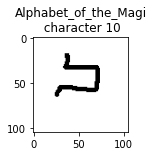

In [6]:
num_alphabets = 1
num_samples = 1
img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
alphabet_names = [a for a in os.listdir(img_dir) if a[0] != '.'] # get folder names

for a in range(num_alphabets): # for each alphabet
        print('generating figure ' + str(a+1) + ' of ' + str(num_alphabets))
        alpha_name = alphabet_names[a]
        
        # choose a random character from the alphabet
        character_id = random.randint(1,len(os.listdir(os.path.join(img_dir,alpha_name))))

        # get image directory for this character
        img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(character_id))


        # get base file name for this character
        fn_example = os.listdir(img_char_dir)[0]
        fn_base = fn_example[:fn_example.find('_')] 

        plt.figure(a,figsize=(10,8))
        plt.clf()
        for r in range(1,num_samples+1): # for each rendition
            plt.subplot(4,5,r)
            fn_img = img_char_dir + '/' + fn_base + '_' + num2str(r) + '.png'			
            I = load_img(fn_img)
            np.set_printoptions(threshold=np.inf)
            plt.imshow(I, cmap='gray')
            if r==1:
                plt.title(alpha_name[:20] + '\n character ' + str(character_id))


more utility functions to load pixel data for each image in an alphabet and make pairs of images for training

In [7]:
def load_imgs(alphabet_names):
    X = np.array([])
    Y = np.array([])
    for alpha_name in alphabet_names:
        print('loading {} alphabet'.format(alpha_name))
        char_ids = range(1,len(os.listdir(os.path.join(img_dir,alpha_name))) + 1)
        # get image directory for this character
        for char_id in char_ids:
            img_char_dir = os.path.join(img_dir,alpha_name,'character'+num2str(char_id))
            # get list of individual file names for each sample of a character
            img_fns = os.listdir(img_char_dir)
            # np arrays containing data of all samples of a character
            data = np.array([plt.imread(os.path.join(img_char_dir, fn)) for fn in img_fns])
            for i in range(len(img_fns)):
              Y = np.append(Y, alpha_name + '_character'+num2str(char_id)) # within alphabet discrimination
              # Y = np.append(Y, alpha_name) # between alphabet discrimination
            if X.size == 0:
                X = data
            else:
                X = np.vstack((X, data))

        
    return X, Y

def make_pairs(X, Y):

    pairs = []
    labels = []

    for i in range(len(X)):
        if i%1000 == 0:
            print(i)
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        J = [j for j, y in enumerate(Y) if y == class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [1]

        # get non-match
        # get possible indices where x2 is different from x1
        J = [j for j, y in enumerate(Y) if y != class_]
        j = np.random.choice(J)

        x2 = X[j]

        pairs += [[x1, x2]]
        labels += [0]
        
    return np.array(pairs), np.array(labels)



Use our utility function to get training set and test set

In [8]:
def train_test_split(n, alphabet_names):

    train_alphabets = alphabet_names[:n]
    test_alphabets = alphabet_names[n:]

    X_train, Y_train = load_imgs(train_alphabets)
    train_pairs, train_labels = make_pairs(X_train, Y_train)

    X_test, Y_test = load_imgs(test_alphabets)

    return train_pairs, train_labels, X_test, Y_test

In [9]:
def save_data(**kwargs):
    # save it once to allow load from file

    # train_pairs, train_labels and X_test all contain 0s and 1s which can be converted to unsigned 8 bit ints
    # use np.astype(np.uint8) to convert array before saving

    print('saving data...')
    for key, value in kwargs.items():

        with h5py.File('{}.h5'.format(key), 'w') as hf:

           if type(value).__module__ == np.__name__:

                # train_pairs and X_test are image sets which are just 0s and 1s
                # train_labels also contain only 0s and 1s which 
                # can be converted to unsigned 8 bit ints
                # use np.astype(np.uint8) to convert array before saving

                value = value.astype(np.uint8)
                hf.create_dataset(key, value.shape, h5py.h5t.STD_U8BE, data = value)
                print('saved {} as {}.h5!'.format(key, key))

           else:

                # Y_test is a list that contains np strings of class names 
                # np strings are not supported by h5 (save as normal python list of strings before saving)
                value = list(map(str, value))
                hf.create_dataset(key, data = value)
                print('saved {} as {}.h5!'.format(key, key))
            
    
    return None

In [19]:
train_pairs3=np.zeros((25320, 2, 105, 105, 3))
for i in range(len(train_pairs)):
    for j in range(2):
        img = np.stack((train_pairs[i][j],)*3, axis=-1)
        train_pairs3[i][j] = img 

In [20]:
save_data(train_pairs3=train_pairs3)

saving data...
saved train_pairs3 as train_pairs3.h5!


In [21]:
X_test.shape

(6620, 105, 105)

In [22]:
X_test3=np.zeros((6620, 105, 105, 3))
for i in range(len(X_test)):
 
    img = np.stack((X_test[i],)*3, axis=-1)
    X_test3[i] = img
X_test3.shape

(6620, 105, 105, 3)

In [23]:
save_data(X_test3=X_test3)

saving data...
saved X_test3 as X_test3.h5!


In [10]:
# train_a = alphabet_names[:20]
# test_a = alphabet_names[20:]
# X_train, Y_train = load_imgs(train_a)
# X_test, Y_test = load_imgs(test_a)
# save_data(Y_train=list(Y_train), X_test=X_test)

In [11]:
#load from file
def load_data(**kwargs):

    all_data = {}

    for key, value in kwargs.items():

        if value:

            with h5py.File('{}.h5'.format(key), 'r') as hf:

                if type(hf[key][0]) == bytes:
             
                    data = [item.decode('utf8') for item in hf[key][:]] # convert from bytes to str
                else:
                    data = hf[key][:]

                all_data.update({key : data}) 
                print('{} loaded from {}.h5!'.format(key, key))

    return all_data


Load our data and assign to variables

In [114]:
# resulting variable name as key, value is filename to load
kwargs = {'train_pairs' : True, 
          'train_labels' : True,
          'X_test' : True,
          'Y_test' : True,
          'X_train' : True,
          'Y_train' : True,
          'X_ft' : False, 
          'Y_ft' : False,
          'X_test_partial' : False,
          'Y_test_partial' : False}
data = load_data(**kwargs)


train_pairs loaded from train_pairs.h5!
train_labels loaded from train_labels.h5!
X_test loaded from X_test.h5!
Y_test loaded from Y_test.h5!
X_train loaded from X_train.h5!
Y_train loaded from Y_train.h5!


In [115]:
X_test = data['X_test']
Y_test = data['Y_test']
X_train = data['X_train']
Y_train = data['Y_train']
train_pairs = data['train_pairs']
train_labels = data['train_labels']
# X_ft = data['X_ft']
# Y_ft = data['Y_ft']
# X_test = data['X_test_partial']
# Y_test = data['Y_test_partial']


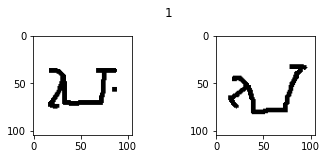

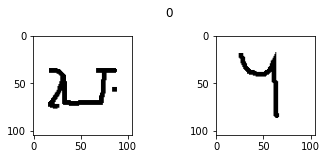

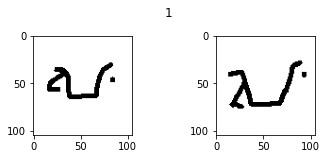

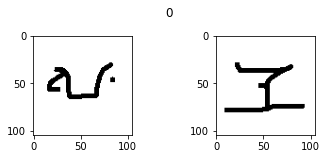

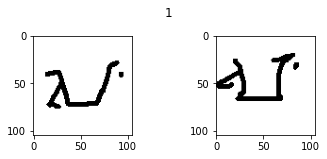

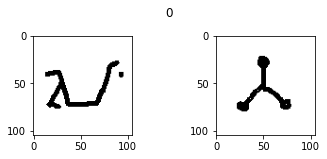

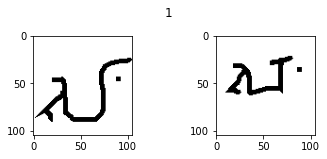

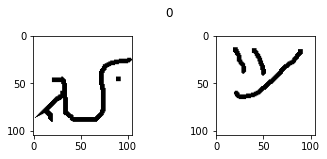

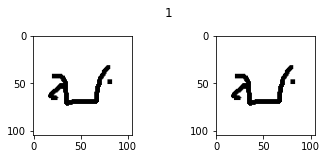

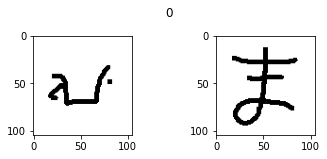

In [15]:
for i in range(10):
    
    fig = plt.figure()
    fig.suptitle(train_labels[i])
    plt.subplot(2,2,1)
    plt.imshow(train_pairs[i][0], cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(train_pairs[i][1], cmap='gray')

Callbacks to stop training our model when loss on validation set is increasing

In [16]:
BATCH_SIZE = 16

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, val_inputs, val_labels, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.val_inputs = val_inputs
        self.val_labels = val_labels

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_begin(self, epoch, logs=None):
        if epoch != 0:
            print('\n\n')

    def on_epoch_end(self, epoch, logs=None):
        
        print('\nEvaluating model on validations set')
        metrics = self.model.evaluate(x=self.val_inputs, y=self.val_labels, batch_size=BATCH_SIZE, verbose=1, sample_weight=None, steps=None, return_dict = True)
        current = metrics['loss']

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch + 1))

Create our model!

In [17]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network

    model = Sequential()
    
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                        kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), 
                        kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.01),
                        bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid',
                    kernel_regularizer=l2(1e-3),
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=0.1),
                    bias_initializer=keras.initializers.RandomNormal(mean=0.5, stddev=0.01)))
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net  

In [18]:
model = get_siamese_model((105,105,1))
optimizer = Adam(lr = 0.00009)
model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         20071232    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]             

split our training data into training and validation sets to keep track of overfitting

In [46]:
from sklearn.model_selection import train_test_split
train_pairs, val_pairs, train_labels, val_labels = train_test_split(train_pairs, train_labels, test_size=0.1, random_state=42)
val_inputs = [val_pairs[:,0], val_pairs[:,1]]

print(train_pairs.shape, val_pairs.shape)

(22788, 2, 105, 105) (2532, 2, 105, 105)


train our model!

In [177]:
model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, batch_size=BATCH_SIZE, epochs=5, callbacks=[EarlyStoppingAtMinLoss(patience=1, val_inputs=val_inputs, val_labels=val_labels)])

Epoch 1/5
40/40 [==============================] - 27s 678ms/step - loss: 109.2916 - accuracy: 0.8641

Evaluating model on validations set
10/10 [==============================] - 2s 167ms/step - loss: 106.7843 - accuracy: 0.6875
Epoch 2/5



40/40 [==============================] - 28s 708ms/step - loss: 104.0428 - accuracy: 0.8859

Evaluating model on validations set
10/10 [==============================] - 2s 175ms/step - loss: 101.7077 - accuracy: 0.6875
Restoring model weights from the end of the best epoch.
Epoch 00002: early stopping


save our model!

In [ ]:
model.save('inset_fn.h5')

or we can load a model!

In [12]:

fn = 'model_8.h5'
model = load_model(fn)
model.summary()
model.get_config()
# model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels[:], batch_size=16, epochs=2)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 2048)         20071232    input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 2048)         0           sequential_11[0][0]       

{'name': 'model_11',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 105, 105, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_23'},
   'name': 'input_23',
   'inbound_nodes': []},
  {'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 105, 105, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_24'},
   'name': 'input_24',
   'inbound_nodes': []},
  {'class_name': 'Sequential',
   'config': {'name': 'sequential_11',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 105, 105, 1),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'conv2d_44_input'}},
     {'class_name': 'Conv2D',
      'config': {'name': 'conv2d_44',
       'trainable': True,
       'batch_input_shape': (None, 105, 105, 1),
       'dtype': 'float32',
       'filters': 64,
       'kernel_size': (10, 10),
       's

make a function to generate a random n-way-k-shot test (including query image and support set) to test our model

In [25]:
def get_test(X_test, Y_test, N, K):
    
    # get num_tests amount of queries and support sets (n way k shot)
    # final output is a list of lists of tuples. Each inner list is a test containing tuple pairs in the form: [(Q, s1), (Q, s2),..., (Q, sk)]
    # where Q is the query img and s1 to sk are k imgs of the support set
    # second output is a list of targets(answers)
    # init lists of queries and support sets

    support_set = []
    targets= np.zeros(N*K)
    test_classes = list(set(Y_test))
   
    # choose random index
    i = np.random.randint(0, len(X_test))

    # get query img and corresponding label
    query = X_test[i]
    label = Y_test[i]
    
    # get 1 * K pairs that is same class
    for k in range(K):
        pos_j = [j for j, class_ in enumerate(Y_test) if class_ == label]
        j = np.random.choice(pos_j)

        pair = [query, X_test[j]]
        targets[k] = 1
        support_set.append(pair)

    # get n-1 * K pairs that are of diff class
    test_classes.remove(label)

    support_classes = []
    for n in range(N-1):

        random_class = np.random.choice(test_classes)
        support_classes.append(random_class)        
    
        for k in range(K):
            
            pos_j = [j for j, class_ in enumerate(Y_test) if class_ == random_class]
            j = np.random.choice(pos_j)
            pair = [query, X_test[j]]
            support_set.append(pair)
            
        test_classes.remove(random_class)

   
    # shuffle support set and add to all support sets
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    

In [14]:
def get_alphabet_test(X_test, Y_test, test_alphabets):

    img_dir = r'C:\Users\Admin\few_shot_learning\keras-one-shot\images_background'
    
    # choose random alphabet from test alphabets
    query_alphabet = np.random.choice(test_alphabets)

    # choose random char from all characters of alphabet, and get up to 19 other characters as support set
    num_chars = len(os.listdir(os.path.join(img_dir, query_alphabet)))
   
    # pick up to 20 in total of random characters
    N = min(20, num_chars)
    id_range = range(1,num_chars)
    pos_chars = np.random.choice(id_range, size=N)

    query_char = '_character{}'.format(num2str(pos_chars[0])) 

    # the label of the query image
    label = query_alphabet + query_char
    
    # init
    support_set = []
    targets = np.zeros(N)
    
    # choose query and support set pair image corresponding to the chosen label
    pos_i = [i for i, class_ in enumerate(Y_test) if class_ == label]
    i = np.random.choice(pos_i)
    query = X_test[i]
    
    pos_j = [j for j, class_ in enumerate(Y_test) if class_ == label]
    j = np.random.choice(pos_j)
    support_img = X_test[j]

    # add as first item of support set 
    support_set.append([query, support_img])
    targets[0] = 1

    # all available classes for the support set 
    support_classes = ['{}_character{}'.format(query_alphabet, num2str(i)) for i in pos_chars[1:]]

    # iterate through the list and add 1 random image from each class to support set (excluding the label)
    for item in support_classes:
        
        pos_j = [j for j, class_ in enumerate(Y_test) if class_ == item]
        j = np.random.choice(pos_j)
        pair = [query, X_test[j]]
        support_set.append(pair)
    
    # shuffle support set and targets 
    support_set, targets = shuffle(support_set, targets)

    return np.array(support_set), np.array(targets)
    
   

Testing the above function

(20, 2, 105, 105)


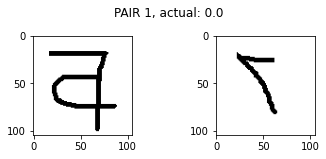

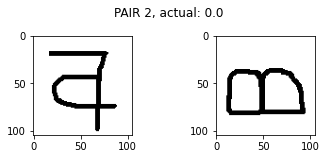

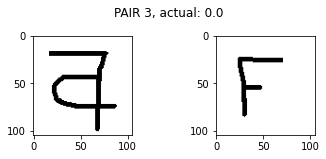

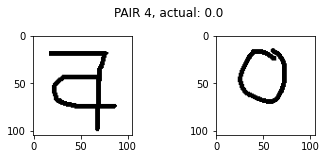

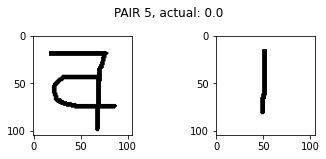

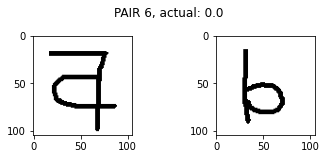

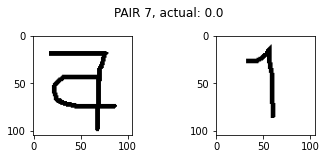

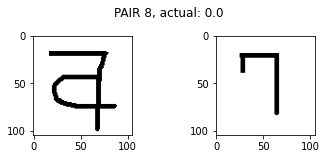

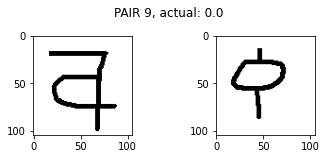

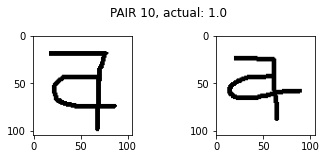

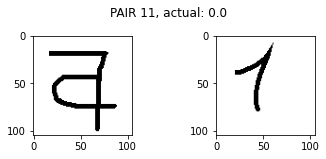

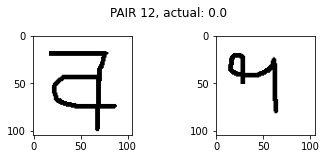

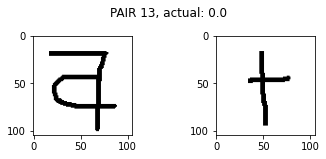

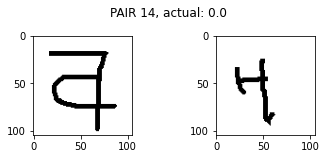

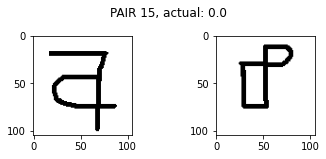

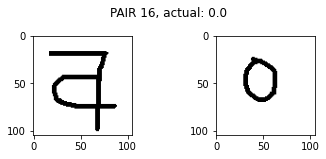

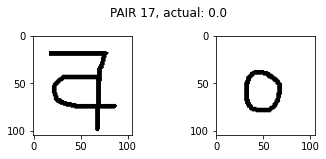

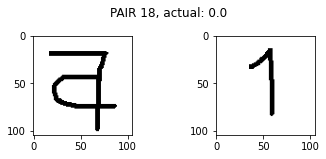

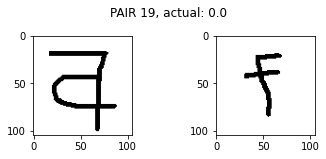

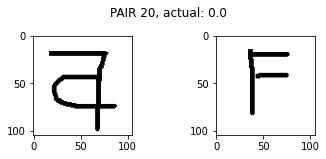

In [15]:
test_alphabets = alphabet_names[20:]

support_set20, targets20 = get_alphabet_test(X_test, Y_test, test_alphabets)
print(support_set20.shape)

for i in range(len(support_set20)):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax1.imshow(support_set20[i][0], cmap='gray')
    ax2 = fig.add_subplot(222)
    ax2.imshow(support_set20[i][1], cmap='gray')
    fig.suptitle('PAIR {}, actual: {}'.format( i+1, targets20[i]))

Create a model class for testing of our FSL model against 2 baselines (random guess and nearest neighbour) for validation

In [135]:
class Predictor(object):

    def __init__(self, name):
        self.n_correct = 0
        self.num_tests = 0
        self.name = name
        self.prediction = None
        self.use_training_set = False
        self.only_supports_rgb = False
    
    def reset(self):
        self.n_correct = 0
        self.num_tests = 0
        self.prediction = None

    def get_name(self):
        return self.name

    def get_n_correct(self):
        return self.n_correct

    def get_num_tests(self):
        return self.num_tests

    def get_prediction(self):
        return self.prediction

    def set_prediction(self, support_set, targets):
        # to be overridden by subclasses
        self.prediction = 0

    def update_score(self, support_set, targets, verbose):
        self.set_prediction(support_set, targets)
        if targets[self.get_prediction()] == 1:
            self.n_correct += 1
        self.num_tests += 1

        if verbose and self.get_num_tests() < 10:
            print('TEST {}'.format(self.get_num_tests()))
            print('{} GUESSED PAIR {}'.format(self.get_name(), self.get_prediction() + 1))
    
            if targets[self.get_prediction()] == 1:
                print("CORRECT")
            else:
                print("INCORRECT")
            print('\n')

    def calc_accuracy(self, N, K):
        acc = round((self.n_correct/self.num_tests) * 100, 2)
        print("{} Model achieved {}% accuracy on {} {}-way {}-shot tests".format(self.get_name(), acc, self.get_num_tests(), N, K))
        return acc
   



In [136]:
class FSL(Predictor):

    def __init__(self, model, name='Few Shot Learning', use_training_set=False, only_supports_rgb=False):
        super().__init__(name)
        self.model = model
        self.name = name
        self.probs = None
        self.use_training_set = use_training_set
        self.only_supports_rgb = only_supports_rgb
        
    def get_probs(self):
        return np.round(self.probs, 4) 

    def set_prediction(self, support_set, targets):
        probs = self.model.predict([support_set[:,0], support_set[:,1]])
        self.probs = probs
        self.prediction = np.argmax(probs)
    
        

In [139]:
class Random(Predictor):

    def __init__(self, name = 'Random Guess'):
        super().__init__(name)
        self.name = name
       
   
    def set_prediction(self, support_set, targets):
        self.prediction = np.random.randint(0, len(support_set))
       


class Nearest_Neighbour(Predictor):

    def __init__(self, name ='Nearest Neighbour'):
        super().__init__(name)
        self.name = name
 
    def set_prediction(self, support_set, targets):
        # picks the class of image in the support set which has min L1 distance from query image
        min_dist = 10e9
        prediction = None
        for i in range(len(support_set)):
            pair = support_set[i]
            curr_dist = np.linalg.norm(pair[0].flatten() - pair[1].flatten(), ord=1)
            if curr_dist < min_dist:
                min_dist = curr_dist
                prediction = i
        self.prediction = prediction

In [158]:
def test_models(models, X_test, Y_test, num_tests, N, K, verbose = 0):
    """function to test any or all of our models that belong to the same Model class on the same test set of
    N way K shot cases over num_test tasks. Use verbose=1 setting to output prediciton data and create relevant visualisations!"""
    
    # limit number of graphs to be plotted for visualisation
    MAX_GRAPHS = 20
    CURR_GRAPHS = 0

    if verbose:
        print("Evaluating models on {} random {} way {} shot learning tasks ... \n".format(num_tests, N, K))


    for num in range(num_tests):
        
        support_set, targets = get_test(X_test, Y_test, N, K)

        for model in models:
            
            copy_support_set = support_set[:]
            copy_targets = targets[:]

            if model.use_training_set:
                # 'Test' this model on the training set (for comparison purposes)
                copy_support_set, copy_targets = get_test(X_train, Y_train, N, K)
        
            if model.only_supports_rgb:
                # Convert 1 channel images to 3 channel for prediction
                copy_support_set3=np.zeros(copy_support_set.shape +(3,))

                for i in range(len(copy_support_set)):
                    for j in range(2):
                        img = np.stack((copy_support_set[i][j],)*3, axis=-1)
                        copy_support_set3[i][j] = img

                copy_support_set = copy_support_set3

            model.update_score(copy_support_set, copy_targets, verbose)

            
           

            if isinstance(model, type(FSL(model))) and verbose and CURR_GRAPHS <= MAX_GRAPHS:

                for i in range(len(support_set)):
        
                    fig = plt.figure()
                    ax1 = fig.add_subplot(221)
                    ax1.imshow(support_set[i][0], cmap='gray')
                    ax2 = fig.add_subplot(222)
                    ax2.imshow(support_set[i][1], cmap='gray')
                    fig.suptitle('TEST {}, PAIR {}\n{}: {}, actual: {}'.format(num + 1, i+1, model.name, model.get_probs()[i], targets[i]))

                    CURR_GRAPHS += 1

    accuracy = {}
    for model in models:
        accuracy.update({model.name : model.calc_accuracy(N, K)})
    return accuracy

In [172]:
# Our siamese network that we trained on the training dataset only
scratch_model = load_model('model_8.h5')

# Siamese net that was pretrained on large scale dataset and fine tuned with our trainng datset
fine_tuned_model = load_model('vgg16')

# Same as above, except it was not fine tuned to our training set
pretrained_model = get_pretrained_model((105,105,3))

optimizer = Adam(lr = 0.00009)
pretrained_model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
pretrained_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 4608)         14714688    input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4608)         0           Embedding[0][0]            

In [169]:
def get_accuracy(models, N, num_tests):
    # tests model against baseline in num_tests amount of n-way 1-shot tasks (n belongs to N)
    # gets mean accuracy over the tests and plots graph of accuracy against n for all n in N

    # init 
    accuracies = {name : [] for name in [model.name for model in models]}
    accuracies.update({'range_' : N})
    for n in N:

        if n == 1:
            for k, v in accuracies.items():
                accuracies[k].append(100)
            continue

        accuracy = test_models(models, X_test, Y_test, num_tests, n, K=1, verbose = 0)

        # reset attributes of models
        for model in models:
            model.reset()

        for k, v in accuracy.items():
            accuracies[k].append(v)

    return accuracies

def plot_accuracy(accuracies, save=None):
    
    plt.figure()

    N = accuracies['range_']
    for k, v in accuracies.items():

        # ignore the range entry (they are the x values)
        if k != 'range_':
            plt.plot(N, v, label=k)

    # Set the axes labels and fix x axise intervals
    plt.xlabel('# of Classes')
    plt.xticks(N)
    plt.xlim(N[0], N[-1]+1)
    
    plt.ylabel('Model Accuracy (%)')

    # Set title of the current axes.
    plt.title('Prediction Accuracy vs # of Classes in 1-Shot Support Set')

    # show legend on the plot
    plt.legend()

    if save:
        plt.savefig(save)
        print("Graph was saved as {}!".format(save))

    # Display the figure.
    plt.show()


We can now get the accuracies of any combination of models of our choosing over a set number of tests, and plot them!

In [ ]:
N = range(1, 11)
NUM_TESTS = 1000
models = [
         FSL(scratch_model), 
         FSL(scratch_model, name='Few Shot Learning (Training)', use_training_set=True)], 
         FSL(pretrain_model, name='Few Shot Learning (Pretrained)', only_supports_rgb=True),
         FSL(pretrain_model, name='FSL (Pretrained) (Training)', use_training_set=True, only_supports_rgb=True) 
         Random(), 
         Nearest_Neighbour(),
         FSL(model, only_supports_rgb=True, name='CNN Nearest Neighbour') 
         ]
accuracies = get_accuracy(models, N, NUM_TESTS)
print(accuracies)

Graph was saved as acc_pretrain_vs_ft.pdf!


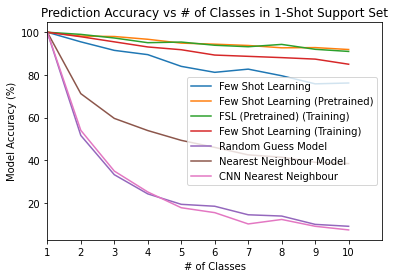

In [168]:
with open('accuracies_160421.txt', 'r') as f:
    contents = f.read()
    accuracies = eval(contents)
plot_accuracy(accuracies, save='acc_pretrain_vs_ft.pdf')


To be used in fine-tuning 

In [13]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 2048)         20071232    input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 2048)         0           sequential_11[0][0]       

In [14]:
layer_name = 'sequential_11'
# If you don't have the original sequential model, it's in the siamese net: (see model.summary() for name of orig sequential model)
extractor = model.get_layer(name=layer_name) 
extractor.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 6, 6, 256)       

In [15]:
def split_ft_set(X_ft, Y_ft, queries_per_class):
    # get n number of images from fine tuning set per class, the rest will form our support set
    pos_classes = list(set(Y_ft))
    queries = []
    labels = []
    support_set = list(X_ft[:])
    support_labels = list(Y_ft[:])
    for y in pos_classes[:]:
        for n in range(queries_per_class):

            pos_i = [i for i, label in enumerate(support_labels) if label == y]
            i = np.random.choice(pos_i)
            queries.append(support_set.pop(i))
            labels.append(support_labels.pop(i))

        pos_classes.remove(y)

    queries, labels = shuffle(queries, labels)

    return np.array(queries), labels, np.array(support_set), support_labels

queries, labels, support_set, support_labels = split_ft_set(X_ft, Y_ft, queries_per_class=5)


In [16]:
print(queries.shape, len(labels))
print(support_set.shape, len(support_labels))
print(X_ft.shape, len(Y_ft))

(900, 105, 105) 900
(2700, 105, 105) 2700
(3600, 105, 105) 3600


visualise our queries and ensure labels are correct

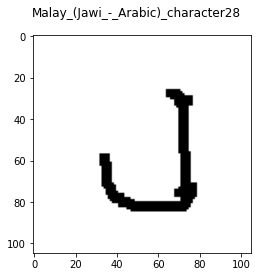

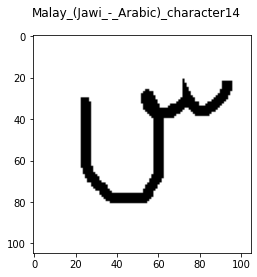

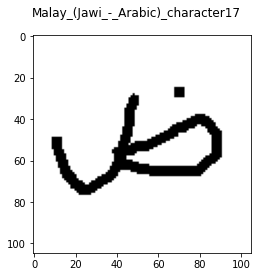

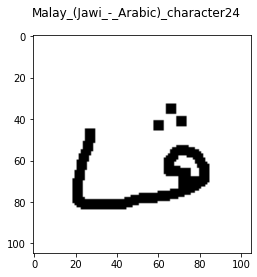

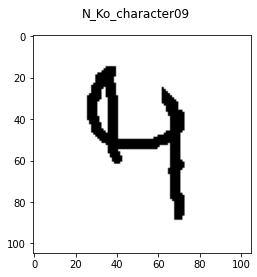

In [127]:
for i in range(5):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.imshow(queries[i], cmap='gray')
    plt.suptitle(labels[i])

do the same with our support set

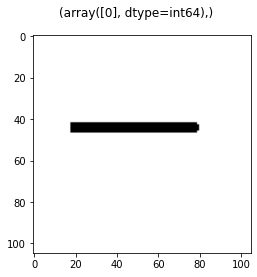

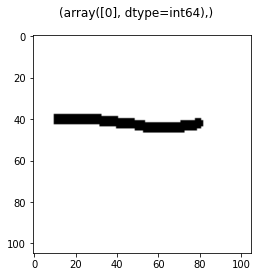

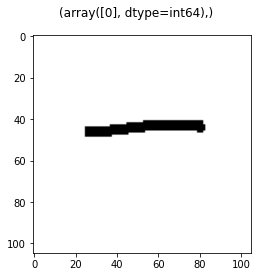

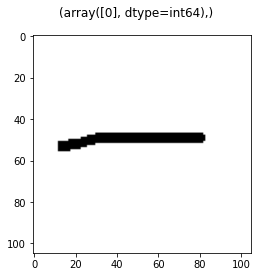

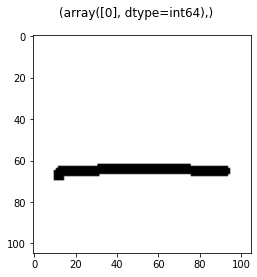

In [231]:
for i in range(0,5):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    # rand_i = np.random.randint(0,len(support_set))
    rand_i = i
    ax1.imshow(support_set[rand_i], cmap='gray')
    plt.suptitle(np.where(enc_support_labels[rand_i] ==1))

In [434]:
def one_hot_encode(mapping, labels, to_sort=[]):
 
    new_labels = labels[:]
    for x in range(len(labels)):
        
        new_labels[x] = mapping[labels[x]]
    
    if len(to_sort) > 0:
        # to sort will be our image set
        to_sort = list(to_sort)

        to_sort = [x for _, x in sorted(zip(new_labels, to_sort), key=lambda pair: pair[0])]
        new_labels = sorted(new_labels)

        one_hot_encode = tf.keras.utils.to_categorical(new_labels)
        return one_hot_encode, to_sort

    one_hot_encode = tf.keras.utils.to_categorical(new_labels)
    return one_hot_encode

In [21]:
mapping = {}

universe = list(set(Y_ft))
new_labels = support_labels[:]

for x in range(len(universe)):
    mapping[universe[x]] = x

# integer representation of our labels
for x in range(len(support_labels)):
        
    new_labels[x] = mapping[support_labels[x]]

support_labels = new_labels
support_set = [x for _, x in sorted(zip(support_labels, support_set), key=lambda pair: pair[0])]
support_labels = sorted(support_labels)


KeyError: 0

In [206]:
print(len(enc_support_labels[0]))
print(len(enc_support_labels[0]) == len(enc_labels[0]))
num_classes = len(enc_labels[0])

180
True


In [34]:
def get_w_init(extractor, support_set, support_labels):
    # compute the mean vector for each class in our support set using all the images
    i = 0
    j = 0
    M = np.array([])
    while i < len(support_set) and j <= support_labels[-1]:
        mu = np.array([])
        while support_labels[i] == j:
            
            v = extractor.predict(support_set[i:i+1])
            # print(v.shape)
            if len(mu)==0:
                mu = v
            else:
                mu = np.vstack((mu, v))
            # print(mu.shape)
            i += 1
            if i == len(support_set):
                break
         

        mu = np.mean(mu, axis=0)
        if len(M) == 0:
            M = mu
        else:
            M = np.vstack((M, mu))
        
        if j%10 == 0:
            print(M.shape)
            print('j', j)
        j += 1
       
    return M

In [27]:
support_set = np.array(support_set).reshape(-1,105,105,1)

In [35]:
M = get_w_init(extractor, support_set, support_labels)
M = M.transpose()

(2048,)
j 0
(11, 2048)
j 10
(21, 2048)
j 20
(31, 2048)
j 30
(41, 2048)
j 40
(51, 2048)
j 50
(61, 2048)
j 60
(71, 2048)
j 70
(81, 2048)
j 80
(91, 2048)
j 90
(101, 2048)
j 100
(111, 2048)
j 110
(121, 2048)
j 120
(131, 2048)
j 130
(141, 2048)
j 140
(151, 2048)
j 150
(161, 2048)
j 160
(171, 2048)
j 170


Build a custom layer that takes in the query feature vector from our CNN and outputs the softmax of our cosine similarities between the query feature vector and each of the mean feature vectors in our support set (This is the initialised version, as the weights will be learnt as we iterate through our support set)

In [502]:
class Distance(keras.layers.Layer):
    def __init__(self, units=32):
        super(Distance, self).__init__()
        self.units = units

    def build(self, input_shape):
        
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.Constant,
            trainable=True,
        )
   
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )
        super(Distance, self).build(input_shape)  # Be sure to call this somewhere!
    def call(self, inputs):
        # print(inputs.shape, self.w.shape)
        inputs = tf.transpose(inputs)
        norm_inputs = tf.linalg.norm(inputs)
        norm_w = tf.linalg.norm(self.w, axis=0)

        unit_inputs = tf.math.divide_no_nan(inputs,norm_inputs)
        unit_w = tf.math.divide_no_nan(self.w,norm_w)
       

        # print(unit_inputs.shape, unit_w.shape)
        cos_sim = tf.tensordot(unit_inputs, unit_w, axes=[0,0]) + self.b

        probs = tf.nn.softmax(cos_sim)
    
        return probs
        

To test if our layer is working, we first build it and intialise its weights matrix to M-> where each row is the mean feature vector of one of the 180 classes in our support set. 
Then if we pass a row from M, since the vector in that row is the same as the corresponding row in our weights matrix. The index of the max of the resulting output should be equal to the index of the row we input! (Since it has highest similarity and softmax function preserves the rankings)

In [514]:

num_classes = M.shape[-1]
num_features = M.shape[0]

ft_layer = Distance(num_classes) # 180 units i.e 180 nodes 1 for each class

ft_layer.build((1, num_features)) # input shape 1x2048 matrix

# init weights with our matrix
ft_layer.set_weights([M, np.zeros(180,)])

# check to see that our weights have been set properly
print(ft_layer.get_weights()[0][0][:10], M[0][:10])

# test as above
for i in range(10):
    activation = ft_layer(M[:, i]).numpy()
    
    max_index = np.where(activation == max(activation))[0]
    
    if max_index == i:
        print("TRUE")

[0.79589283 0.31238344 0.7315918  0.7021388  0.6175479  0.45318633
 0.63270193 0.404012   0.40905228 0.49660397] [0.79589283 0.31238344 0.7315918  0.7021388  0.6175479  0.45318633
 0.63270193 0.404012   0.40905228 0.49660397]
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


In [515]:
model = Sequential()
for layer in extractor.layers:
    model.add(layer)
model.add(ft_layer)
model.build((2048,))
model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 6, 6, 256)       

In [516]:
# freeze the parameters of our CNN
for layer in model.layers[:-1]:
    layer.trainable = False

In [517]:
for layer in model.layers:
    print(layer.name, layer.trainable)

conv2d_44 False
max_pooling2d_33 False
conv2d_45 False
max_pooling2d_34 False
conv2d_46 False
max_pooling2d_35 False
conv2d_47 False
flatten_11 False
dense_22 False
distance_161 True


In [518]:
optimizer = Adam(learning_rate = 0.000009)
model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 6, 6, 256)       

In [435]:
enc_labels = one_hot_encode(mapping, labels)

In [449]:
enc_labels


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [544]:
probs = model.predict(queries.reshape(-1, 105,105, 1)[:25])
for i in range(len(probs)):

    max_i = np.where(probs == max(probs[i]))[-1]
    answer = np.where(enc_labels[i]==1)[0]
    print(max_i,answer)
    if max_i == answer:
        print("CORRECT")
    else:
        print("WRONG")

[50] [49]
WRONG
[122] [122]
CORRECT
[94] [94]
CORRECT
[134] [134]
CORRECT
[52] [69]
WRONG
[143] [46]
WRONG
[176] [176]
CORRECT
[76] [76]
CORRECT
[82] [82]
CORRECT
[8] [160]
WRONG
[20] [20]
CORRECT
[88] [88]
CORRECT
[128] [86]
WRONG
[132] [132]
CORRECT
[31] [148]
WRONG
[54] [162]
WRONG
[103] [133]
WRONG
[161] [78]
WRONG
[5] [22]
WRONG
[19] [137]
WRONG
[33] [33]
CORRECT
[39] [39]
CORRECT
[150] [49]
WRONG
[40] [43]
WRONG
[121] [121]
CORRECT


In [466]:
queries.reshape(-1, 105,105, 1).shape

(900, 105, 105, 1)

In [500]:
fx = extractor.predict(queries[0:1])

In [501]:
ft_layer(fx.transpose())

<tf.Tensor: shape=(1, 180), dtype=float32, numpy=
array([[0.00521733, 0.00555415, 0.00580922, 0.00540108, 0.00565699,
        0.00539393, 0.00555143, 0.00549563, 0.00566813, 0.00552523,
        0.00560853, 0.00577408, 0.00558183, 0.00580277, 0.00554094,
        0.00565107, 0.00575139, 0.00542107, 0.00524574, 0.00547705,
        0.00574222, 0.00576239, 0.00549683, 0.00571783, 0.00575023,
        0.00553978, 0.00558824, 0.00564614, 0.00564223, 0.0055488 ,
        0.00541082, 0.00553762, 0.0055937 , 0.00559001, 0.00551477,
        0.00540671, 0.00571215, 0.00563588, 0.00562165, 0.00540343,
        0.00565882, 0.00542572, 0.00538492, 0.00540195, 0.00573418,
        0.00573595, 0.00563434, 0.00551237, 0.00566001, 0.00594076,
        0.00600349, 0.0057761 , 0.00574984, 0.00510005, 0.00577174,
        0.00568384, 0.00568734, 0.00551775, 0.00563702, 0.00520368,
        0.00560569, 0.00561564, 0.00540989, 0.00519635, 0.00561775,
        0.00547012, 0.00529344, 0.00574223, 0.00551311, 0.00569413

In [171]:
def get_pretrained_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    pre_train = Sequential()
    base = VGG16(include_top=False, input_shape=input_shape)

    # freeze all layers but last 4
    for layer in base.layers[:-4]:
        layer.trainable = False
    
    pre_train.add(base)
    pre_train.add(tf.keras.layers.Flatten())
    embedding = Model(pre_train.input, pre_train.output, name="Embedding")
    
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = embedding(left_input)
    encoded_r = embedding(right_input)
    
 
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
  

    # # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)


    # # Connect the inputs with the outputs
    pretrained_model = Model(inputs=[left_input,right_input], outputs=prediction)

    # return the model
    return pretrained_model


In [649]:
from sklearn.model_selection import train_test_split
train_pairs = train_pairs.reshape(-1, 2, 105, 105, 3)
print(train_pairs.shape)
train_pairs2, val_pairs, train_labels, val_labels = train_test_split(train_pairs2, train_labels, test_size=0.1, random_state=42)
val_inputs = [val_pairs[:,0], val_pairs[:,1]]

print(train_pairs.shape, val_pairs.shape)

(8440, 2, 105, 105, 3)
(8440, 2, 105, 105, 3) (2532, 2, 105, 105, 3)


In [659]:
model.evaluate(x=[val_pairs[:,0], val_pairs[:,1]], y= val_labels)

80/80 [==============================] - 83s 1s/step - loss: 0.1506 - accuracy: 0.9589


[0.150559201836586, 0.958925724029541]

In [666]:
BATCH_SIZE=64
model.fit([train_pairs2[:,0], train_pairs2[:,1]], train_labels, batch_size=BATCH_SIZE, epochs=10, callbacks=[EarlyStoppingAtMinLoss(patience=0, val_inputs=val_inputs, val_labels=val_labels)])

Epoch 1/10
357/357 [==============================] - 1106s 3s/step - loss: 0.0326 - accuracy: 0.9959

Evaluating model on validations set


AttributeError: 'EarlyStoppingAtMinLoss' object has no attribute 'val_inputs'

In [661]:
model.save('vgg16')

INFO:tensorflow:Assets written to: vgg16\assets
INFO:tensorflow:Assets written to: vgg16\assets
